# Effect of $\epsilon$ on Average Treatment Effect

In [1]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.special import erf
import torch

from torch.autograd import Variable

from misc.agm import calibrateAnalyticGaussianMechanism

%matplotlib inline

import pdb

# set random seed
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# no. experiments, no. samples, dim, X
ne = 500
ns = 2000
dim = 50

# true treatment effect tau
tau = 0.1

# draw ne separate ns samples
X_std = 3
X_dist = torch.distributions.normal.Normal(
    torch.tensor([0.0], dtype=torch.float64), 
    torch.tensor([X_std], dtype=torch.float64)
)
X  = [X_dist.sample((ns, dim)).squeeze() for i in range(ne)]

# restrict X to ||x||_2 \leq 1 to fit assumption for each experiment
X = torch.stack([X[i] / X[i].norm(dim=1).max() for i in range(ne)])

In [3]:
# no. of points used to fit log reg
nf = 1000

# privacy parameters
# epses = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.4, 0.8, 0.99]
epses = [0, 0.03, 0.05, 0.1, 0.2, 0.4, 0.8, 0.99]
delta = torch.tensor(1e-6)

# regularisation coefficient
reg_co = 0.1

In [4]:
# vectors for generating Y, differentiate between Y_0 and Y_1 with true treatment effect tau
# Y = beta^T X + 0.1 Z
# Y_1 = Y + tau, Y_0 = Y
beta_std = 1
beta_dist = torch.distributions.normal.Normal(
    torch.tensor([0], dtype=torch.float64), 
    torch.tensor([beta_std], dtype=torch.float64)
)
beta = beta_dist.sample((dim, 1)).reshape(dim, 1)

# generate Y
Y_std = 0.1
Y = torch.einsum('kl,ijk->ij',beta,X) + Y_std * torch.randn(ne, ns, dtype=torch.float64)

In [5]:
# vectors for generating T
# T = exp(-T_w^T X + b)
T_std = 1
T_dist = torch.distributions.normal.Normal(
    torch.tensor([0.0], dtype=torch.float64), 
    torch.tensor([T_std], dtype=torch.float64)
)
T_w = T_dist.sample((dim, 1)).reshape(dim, 1)
T_b = 0

# generate T
prob_vec = torch.sigmoid(torch.einsum('kl,ijk->ij', T_w, X) + T_b)
T = torch.bernoulli(prob_vec)

In [6]:
class Log_Reg(torch.nn.Module):
    '''
    Logistic Regression
    '''
    def __init__(self, D_in, D_out):
        super(Log_Reg, self).__init__()
        self.linear = torch.nn.Linear(D_in, D_out, bias=False)
        
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

In [7]:
def IPW_PPS_Out(X, T, prob_vec, Y, tau, epses, delta, reg_co, nf):
    '''
    average treatment effect with inverse propensity weighting using private propensity scores
    '''
    # get # experiments, # samples, # dimensions
    ne, ns, dim = X.shape

    ################
    # process data #
    ################

    # get Y0 and Y1
    Y0 = Y * (1 - T)
    Y1 = (Y + tau) * T
    
    # split data
    # get splits
    fit_split = nf
    est_split = ns - nf

    # permute indices
    perm = torch.stack(
        [torch.randperm(ns) for i in range(ne)]
    )

    # create splits
    s0 = perm[:, :fit_split]
    s1 = perm[:, fit_split:]

    # create auxiliary indices
    idx = torch.arange(ne)[:, None]

    # split X into fit, estimate splits
    X_s0 = X[idx, s0]
    X_s1 = X[idx, s1]

    # expand dim of T to allow multiplication with X
    T_ex_dim = T.reshape(ne, ns, 1)

    # split X0 and X1 into fit, estimate splits
    X0_s1 = (X * (1 - T_ex_dim))[idx, s1]
    X1_s1 = (X * T_ex_dim)[idx, s1]

    # split T into fit, estimate splits
    T_s0 = T[idx, s0]
    T_s1 = T[idx, s1]

    # split Y0 and Y1 into fit, estimate splits
    Y0_s0 = Y0[idx, s0]
    Y1_s0 = Y1[idx, s0]

    Y0_s1 = Y0[idx, s1]
    Y1_s1 = Y1[idx, s1]
    
    ##############
    # fit models #
    ##############
    
    models = []
    
    for expm in range(ne):
        X = Variable(X_s0[expm], requires_grad=True)
        T = Variable(T_s0[expm][:, None])
        model = Log_Reg(dim, 1).double()
        opt = torch.optim.LBFGS(model.parameters(), max_iter=100)

        # define first-order oracle for lbfgs
        def closure():
            if torch.is_grad_enabled():
                opt.zero_grad()
            outputs = model(X)
            for weights in model.parameters():
                loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, T) + 0.5 * reg_co * weights.norm(2).pow(2)
            if loss.requires_grad:
                loss.backward()
            return loss

        opt.step(closure)

        models.append(model)

    #############################
    # estimate treatment effect #
    #############################

    # initialise pi_hat dictionaries
    pi_hats = {}
    
    # initialise e dictionary
    e = {}
    
    # intialise sigma dictionary
    sig_d = {}

    # get estimated propensity scores
    pi_hats[0] = torch.stack(
        [models[i](X_s1[i]).squeeze() for i in range(ne)]
    )

    # perturb model and get relevant quantities
    for eps in epses[1:]:
        # define sensitivity for log reg
        s_w = 2.0 / (fit_split * reg_co)

        # define sigma for log reg
        sigma = np.sqrt(
            2 * np.log(1.25 / delta) + 1e-10
        ) * (s_w / (eps / 2))
        sigma_2 = sigma ** 2

#         # analytic gaussian mechanism
#         sigma = calibrateAnalyticGaussianMechanism(eps, delta, s_w)
#         sigma_2 = sigma ** 2

        # define z distribution for log reg
        z_dist = torch.distributions.normal.Normal(
            torch.tensor(0.0, dtype=torch.float64),
            torch.tensor(sigma, dtype=torch.float64),
        )

        # draw z for log reg
        z_vecs = z_dist.sample((ne, dim))

        # create temp models
        models_ = copy.deepcopy(models)

        # initialise list for privatised estimated propensity scores
        pi_hats[eps] = []

        # perturb weights with z_vecs
        for i in range(ne):
            model_temp = models_[i]
            model_temp.linear.weight.data.add_(
                z_vecs[i]
            )
            pi_hats[eps].append(
                model_temp(X_s1[i]).squeeze()
            )

        # reshape stacked privatised estimated propensity scores
        pi_hats[eps] = torch.stack(pi_hats[eps])
                        
        # max of abs of Y1_s1 / propensity score for each experiment
        max_abs_Y1_s1_div_ps = torch.max(
            torch.abs(Y1_s1) / ((ns - nf) * pi_hats[eps]), 1
        )[0]
        
        # max of abs of Y0_s1 / (1 - propensity score) for each experiment
        max_abs_Y0_s1_div_1_m_ps = torch.max(
            torch.abs(Y0_s1) / ((ns - nf) * (1 - pi_hats[eps])), 1
        )[0]
        
        # hstack max_abs_Y_s1_div_ps and max_abs_Y_s1_div_1_m_ps
        max_abs_all = torch.stack(
            (max_abs_Y1_s1_div_ps, max_abs_Y0_s1_div_1_m_ps), 1
        )
        
        # replace inf/nan with 1e20 for stability
        max_abs_all[torch.isfinite(max_abs_all) == 0] = 1e20
            
        # define sensitivity for estimation
        s_e = 2 * torch.max(max_abs_all, 1)[0]
        
        # define sigma for estimation
        sigma_e = np.sqrt(
            2 * np.log(1.25 / delta) + 1e-10
        ) * (s_e / (eps / 2))
        sig_d[eps] = sigma_e.detach().numpy()
        sigma_e_2 = sigma_e ** 2
        
#         # analytic gaussian mechanism
#         sigma_e = calibrateAnalyticGaussianMechanism(eps, delta, s_e)
#         sigma_e_2 = sigma_e ** 2

        # define e distribution for estimation
        e_dist = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.tensor([0.0], dtype=torch.float64),
            torch.diag(sigma_e)
        )

        # draw e for estimation
        e[eps] = e_dist.sample().reshape(ne)
    
    # get treatment effects
    # true
    te = {}
    # empirical means and std of means of ERM + private ERM
    te_hats = {'means': [], 'stds': []}
    # means and std of means of privatised te_hats
    te_hats_p = {'means': [], 'stds': []}

    # estimate true treatment effect
    te_ = torch.mean(
        Y1_s1 / prob_vec[idx, s1] - Y0_s1 / (1 - prob_vec[idx, s1]),
        1,
    )
    te['mean'] = te_.mean().detach().numpy()
    te['std'] = te_.std().detach().numpy()
                
    for key in pi_hats.keys():
        # empirical estimate for noiseless case
        # reduce_mean from (ne, est_split) tensor to (ne , 1) matrix
        te_hats_ = torch.mean(
            Y1_s1 / pi_hats[key] - Y0_s1 / (1 - pi_hats[key]),
            1,
        )
        te_hats['means'].append(
            te_hats_.detach().numpy()
        )
        te_hats['stds'].append(
            te_hats_.std().detach().numpy()
        )
        try:
            te_hats_p_ = te_hats_ + e[key]
            te_hats_p['means'].append(
                te_hats_p_.detach().numpy()
            )
            te_hats_p['stds'].append(
                te_hats_p_.std().detach().numpy()
            )
        except KeyError:
            # fill first row for later
            te_hats_p['means'].append(
                te_hats_.detach().numpy()
            )
            te_hats_p['stds'].append(
                te_hats_.std().detach().numpy()
            )
        
    te_hats['means'] = np.array(te_hats['means'])
    te_hats['stds'] = np.array(te_hats['stds'])
    te_hats_p['means'] = np.array(te_hats_p['means'])
    te_hats_p['stds'] = np.array(te_hats_p['stds'])

    return te, te_hats, te_hats_p, sig_d

In [8]:
def IPW_PPS_Obj(X, T, prob_vec, Y, tau, epses, delta, reg_co, nf):
    '''
    average treatment effect with inverse propensity weighting using private propensity scores
    '''
    # get # experiments, # samples, # dimensions
    ne, ns, dim = X.shape

    # objective perturbation constants
    L = 1 # see from derivation, also http://proceedings.mlr.press/v32/jain14.pdf
    R2 = 1 # as norm is bounded by 1
    c = 0.25
    
    
    ################
    # process data #
    ################

    # get Y0 and Y1
    Y0 = Y * (1 - T)
    Y1 = (Y + tau) * T
    
    # split data
    # get splits
    fit_split = nf
    est_split = ns - nf

    # permute indices
    perm = torch.stack(
        [torch.randperm(ns) for i in range(ne)]
    )

    # create splits
    s0 = perm[:, :fit_split]
    s1 = perm[:, fit_split:]

    # create auxiliary indices
    idx = torch.arange(ne)[:, None]

    # split X into fit, estimate splits
    X_s0 = X[idx, s0]
    X_s1 = X[idx, s1]

    # expand dim of T to allow multiplication with X
    T_ex_dim = T.reshape(ne, ns, 1)

    # split X0 and X1 into fit, estimate splits
    X0_s1 = (X * (1 - T_ex_dim))[idx, s1]
    X1_s1 = (X * T_ex_dim)[idx, s1]

    # split T into fit, estimate splits
    T_s0 = T[idx, s0]
    T_s1 = T[idx, s1]

    # split Y0 and Y1 into fit, estimate splits
    Y0_s0 = Y0[idx, s0]
    Y1_s0 = Y1[idx, s0]

    Y0_s1 = Y0[idx, s1]
    Y1_s1 = Y1[idx, s1]
    
    ##############
    # fit models #
    ##############

    z_dist = torch.distributions.normal.Normal(
                torch.tensor(0.0, dtype=torch.double),
                torch.tensor(1.0, dtype=torch.double),
                )
    
    models = {}
    
    for eps in epses:
        models[eps] = []
        for expm in range(ne):
            # follows from http://proceedings.mlr.press/v23/kifer12/kifer12.pdf,
            # hessian is bounded by 0.25 * max_eig_val, see https://www.cs.ubc.ca/~schmidtm/Courses/540-W18/L4.pdf
            eig_val, _ = torch.symeig(torch.matmul(X_s0[expm].T, X_s0[expm]))
            Delta = 2 * torch.max(eig_val) / (eps / 2)
            X = Variable(X_s0[expm], requires_grad=True)
            T = Variable(T_s0[expm][:, None].double())
            model = Log_Reg(dim, 1).double()
            opt = torch.optim.LBFGS(model.parameters(), max_iter=100)
            if eps > 0: 
                reg_co_ = reg_co
                # zeta =< 1 for logistic loss
                b = torch.sqrt((8 * (torch.log(2. / delta) + 4 * eps / 2)) / ((eps / 2) ** 2)) * z_dist.sample((dim, 1))
            
            # define first-order oracle for lbfgs
            def closure():
                if torch.is_grad_enabled():
                    opt.zero_grad()
                outputs = model(X)
                if eps > 0:
                    for weights in model.parameters():
                        reg_noise = (1 / nf) * torch.matmul(weights, b) + 0.5 * (reg_co_ + 0.25 * Delta / nf) * weights.pow(2).sum(1) 
                else:
                    for weights in model.parameters():
                        reg_noise = 0.5 * reg_co * weights.norm(2).pow(2)
                loss = torch.nn.functional.binary_cross_entropy_with_logits(outputs, T) + reg_noise
                if loss.requires_grad:
                    loss.backward()
                return loss
            
            opt.step(closure)

            models[eps].append(model)
      
    #############################
    # estimate treatment effect #
    #############################

    # initialise pi_hat dictionaries
    pi_hats = {}
    
    # initialise e dictionary
    e = {}
    
    # intialise sigma dictionary
    sig_d = {}

    # get estimated propensity scores
    pi_hats[0] = torch.stack(
        [models[0][i](X_s1[i]).squeeze() for i in range(ne)]
    )

    for eps in epses[1:]:
        # get perturbed propensity scores
        pi_hats[eps] = torch.stack(
            [models[eps][i](X_s1[i]).squeeze() for i in range(ne)]
        )
                
        # max of abs of Y1_s1 / propensity score for each experiment
        max_abs_Y1_s1_div_ps = torch.max(
            torch.abs(Y1_s1) / ((ns - nf) * pi_hats[eps]), 1
        )[0]
                
        # max of abs of Y0_s1 / (1 - propensity score) for each experiment
        max_abs_Y0_s1_div_1_m_ps = torch.max(
            torch.abs(Y0_s1) / ((ns - nf) * (1 - pi_hats[eps])), 1
        )[0]
        
        # hstack max_abs_Y_s1_div_ps and max_abs_Y_s1_div_1_m_ps
        max_abs_all = torch.stack(
            (max_abs_Y1_s1_div_ps, max_abs_Y0_s1_div_1_m_ps), 1
        )
                
        # replace inf/nan with 1e20 for stability
        max_abs_all[torch.isfinite(max_abs_all) == 0] = 1e20
            
        # define sensitivity for estimation
        s_e = 2 * torch.max(max_abs_all, 1)[0]
        
        # define sigma for estimation
        sigma_e = np.sqrt(
            2 * np.log(1.25 / delta) + 1e-10
        ) * (s_e / (eps / 2))
        sig_d[eps] = sigma_e.detach().numpy()
        sigma_e_2 = sigma_e ** 2
        
#         # analytic gaussian mechanism
#         sigma_e = calibrateAnalyticGaussianMechanism(eps, delta, s_e)
#         sigma_e_2 = sigma_e ** 2

        # define e distribution for estimation
        e_dist = torch.distributions.multivariate_normal.MultivariateNormal(
            torch.tensor([0.0], dtype=torch.float64),
            torch.diag(sigma_e)
        )

        # draw e for estimation
        e[eps] = e_dist.sample().reshape(ne)
    
    # get treatment effects
    # true
    te = {}
    # empirical means and std of means of ERM + private ERM
    te_hats = {'means': [], 'stds': []}
    # means and std of means of privatised te_hats
    te_hats_p = {'means': [], 'stds': []}

    # estimate true treatment effect
    te_ = torch.mean(
        Y1_s1 / prob_vec[idx, s1] - Y0_s1 / (1 - prob_vec[idx, s1]),
        1,
    )
    te['mean'] = te_.mean().detach().numpy()
    te['std'] = te_.std().detach().numpy()
                
    for key in pi_hats.keys():
        # reduce_mean from (ne, est_split) tensor to (ne, 1) matrix
        te_hats_ = torch.mean(
            Y1_s1 / pi_hats[key] - Y0_s1 / (1 - pi_hats[key]), 
            1,
        )
        te_hats['means'].append(
            te_hats_.detach().numpy()
        )
        te_hats['stds'].append(
            te_hats_.std().detach().numpy()
        )
        try:
            te_hats_p_ = te_hats_ + e[key]
            te_hats_p['means'].append(
                te_hats_p_.detach().numpy()
            )
            te_hats_p['stds'].append(
                te_hats_p_.std().detach().numpy()
            )
        except KeyError:
            # fill first row for later
            te_hats_p['means'].append(
                te_hats_.detach().numpy()
            )
            te_hats_p['stds'].append(
                te_hats_.std().detach().numpy()
            )
        
    te_hats['means'] = np.array(te_hats['means'])
    te_hats['stds'] = np.array(te_hats['stds'])
    te_hats_p['means'] = np.array(te_hats_p['means'])
    te_hats_p['stds'] = np.array(te_hats_p['stds'])

    return te, te_hats, te_hats_p, sig_d


In [9]:
def plot_hist(figname, tau, te_hats, te_hats_p, epses, ne):
    '''
    plot histogram of empirical probabilities of signs flipping for \hat{\tau}_\epsilon and \hat{\tau}_\epsilon_n
    '''
    
    # deal with nans by setting them to be -bias
    for i in range(len(te_hats['means'][1:])):
        # \hat{\tau}_\epsilon
        te_hats['means'][1:][i][
            np.isnan(te_hats['means'][1:][i])
        ] = -tau
        # \hat{\tau}_\epsilon_n
        te_hats_p['means'][1:][i][
            np.isnan(te_hats_p['means'][1:][i])
        ] = -tau

    sgn_tau_hat = np.sign(te_hats['means'][0])

    # compute probabilities
    probs_te_hats = [
        sum(sgn_tau_hat != np.sign(te_hats['means'][1:][i])) / ne
        for i in range(len(te_hats['means'][1:]))
    ]
    
    probs_all = [
#         sum(abs(sgn_tau_hat + np.sign(te_hats['means'][1:][i]) + np.sign(te_hats_p['means'][1:][i])) != 3) / ne
        sum((sgn_tau_hat != np.sign(te_hats['means'][1:][i])).astype('int') + 
            (sgn_tau_hat != np.sign(te_hats_p['means'][1:][i])).astype('int') == 2) / ne
        for i in range(len(te_hats['means'][1:]))
    ]
    
    print(probs_te_hats)
    print(probs_all)
    
    # plot figure
    y_name = "P(sgn($\\hat{\\tau}_n$) $\\neq$ sgn($\\hat{\\tau}$))"
    y_name_all = "P(sgn($\\hat{\\tau}_n^\\epsilon$) $\\neq$ sgn($\\hat{\\tau})$, sgn($\\hat{\\tau}_n$)$\\neq$ sgn($\\hat{\\tau}$))"
        
    ind = np.arange(len(epses))
    width = 0.35     
        
    fig, ax = plt.subplots(1,1, figsize=(8, 6))
    ax.bar(ind, probs_te_hats, width, color='g', label=y_name)
    ax.bar(ind+width, probs_all, width, color='b', label=y_name_all)

    ax.set_title(
        "P(sign change) against $\epsilon$ for $\\tau$ = {}".format(tau),
        fontsize=20,
    )
    ax.set_ylim(0.0, 1.0)
    ax.set_xlabel("privacy loss ($\epsilon$)", fontsize=18)
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels([str(i) for i in epses])
    ax.tick_params(labelsize=16)
    
    ax.legend(fontsize=16)
    
    fig.tight_layout()
    fig.savefig(figname+'.pdf',dpi=100)

In [10]:
def plot_hist_erf(figname, tau, te_hats, te_hats_p, epses, sig_d):
    """
    plot histogram of empirical probabilities of signs flipping for \hat{\tau}_n^\epsilon w.r.t erf(|\hat{\tau}_n}| / sigma_n)
    """

    # deal with nans by setting them to be -bias
    for i in range(len(te_hats["means"][1:])):
        # \hat{\tau}_n
        te_hats["means"][1:][i][
            np.isnan(te_hats["means"][1:][i])
        ] = -tau
        # \hat{\tau}_n^\epsilon
        te_hats_p["means"][1:][i][
            np.isnan(te_hats_p["means"][1:][i])
        ] = -tau

    sgn_tau_hat = np.sign(te_hats["means"][0])

    sgn_list = []
    val_list = []

    for i in range(len(epses)):
        # get sigma
        sigma = sig_d[epses[i]]

        # get sgn and val for eps whose sgn(\hat{\tau}_n) != sgn(\hat{\tau})
        sgn_flip_idx = (
            np.sign(te_hats["means"][i + 1]) != sgn_tau_hat
        )

        # get tau_hat_n of disagreements
        sgn_flip_te_hat = te_hats["means"][i + 1][
            sgn_flip_idx
        ]

        abs_sgn_flip_te_hat_div_sigma = (
            np.abs(sgn_flip_te_hat) / sigma[sgn_flip_idx]
        )

        sgn_list += (
            np.sign(te_hats_p["means"][i + 1][sgn_flip_idx])
            != sgn_tau_hat[sgn_flip_idx]
        ).tolist()

        # add all val where sgn_tau_hat_n != sgn_tau_hat
        val_list += abs_sgn_flip_te_hat_div_sigma.tolist()

    sgn_list = np.array(sgn_list)
    val_list = np.array(val_list)

    # set # of bins
    bins = np.linspace(0, 0.40, 20)

    # bin w.r.t to vals where sgn(\hat{\tau}_n^\epsilon) != sgn(\hat{\tau})
    hist1, bins1 = np.histogram(
        erf(val_list[sgn_list == 1]), bins=bins
    )

    binWidth1 = bins1[1] - bins1[0]

    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    lab_1 = (
        "# of sgn($\\hat{\\tau}_n$) $\\neq$ sgn($\\hat{\\tau}) = $"
        + str(len(val_list))
    )
    lab_2 = (
        "# of sgn($\\hat{\\tau}_n^\\epsilon$) $\\neq$ sgn($\\hat{\\tau}) = $"
        + str(len(val_list[sgn_list == 1]))
    )

    ax.bar(
        bins1[:-1],
        (
            hist1 / len(val_list)
        ),  # divide by number of times where sgn(\hat{\tau}_n) != sgn(\hat{\tau}) to get probability
        binWidth1,
        alpha=0.7,
    )

    ax.set_title(
        "P(sgn($\\hat{\\tau}_n^\\epsilon$) $\\neq$ sgn($\\hat{\\tau}$) | sgn($\\hat{\\tau}_n$) $\\neq$ sgn($\\hat{\\tau}$)) for $\\tau$ = "
        + str(tau),
        fontsize=20,
    )
    ax.tick_params(labelsize=16)
    ax.set_xlabel(
        "erf(|$\\hat{\\tau}_n$|/$\\sigma_n$)", fontsize=18
    )

    empty_leg = Rectangle((0, 0), 0, 0, alpha=0.0)
    ax.legend(
        [empty_leg, empty_leg],
        [lab_1, lab_2],
        handlelength=0,
        fontsize=14,
        frameon=False,
    )

    fig.tight_layout()
    fig.savefig(figname + "_" + str(tau) + ".pdf", dpi=100)


In [11]:
def plot_te(figname, te, te_hats, te_hats_analytic, epses, eps_pos, tau,):
    '''
    plot the true treatment effect, ERM, private ERM treatment effect
    
    eps_pos is the position of the first eps to plot frrom
    '''

    # get means and stds
    te_hat = np.mean([te_hats['means'][0]], 1)
    te_hat_std = np.std([te_hats['means'][0]])
    te_hat_z = np.mean(te_hats['means'][1:], 1)[eps_pos:]
    te_hat_z_std = np.std(te_hats['means'][1:], 1)[eps_pos:]
    te_hat_mu = np.mean(te_hats_analytic['means'], 1)[eps_pos:]
    te_hat_mu_std = (
        np.std(te_hats_analytic['means'], 1)[eps_pos:] + np.mean(te_hats_analytic['stds'], 1)[eps_pos:]
    )

    # plot figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.plot(
        epses[eps_pos:],
        [te['mean']] * len(epses[eps_pos:]),
        marker='o',
        color='magenta',
        label="Truth",
    )
    ax.plot(
        epses[eps_pos:],
        [te_hat] * len(epses[eps_pos:]),
        marker='o',
        color='red',
        label="ERM",
    )
    ax.plot(
        epses[eps_pos:],
        te_hat_z,
        marker='x',
        color='blue',
        label="Empirical Private ERM",
    )
    ax.plot(
        epses[eps_pos:],
        te_hat_mu,
        marker='d',
        color='green',
        label="Analytical Private ERM",
    )
    ax.fill_between(
        epses[eps_pos:],
        te_hat + te_hat_std,
        te_hat - te_hat_std,
        facecolor='red',
        alpha=0.25,
    )
    ax.fill_between(
        epses[eps_pos:],
        te_hat_z + te_hat_z_std,
        te_hat_z - te_hat_z_std,
        facecolor='blue',
        alpha=0.25,
    )
    ax.fill_between(
        epses[eps_pos:],
        te_hat_mu + te_hat_mu_std,
        te_hat_mu - te_hat_mu_std,
        facecolor='green',
        alpha=0.25,
    )

    ax.set_title(
        "True, ERM, Empirical Private ERM and Analytical Private ERM ATE against $\epsilon$",
        fontsize=20,
    )
    ax.set_xlabel("$\epsilon$", fontsize=18)
    # set legend position
    if tau > 0:
        ax.legend(fontsize=16, loc=1)
    else:
        ax.legend(fontsize=16, loc=4)

    fig.tight_layout()
    fig.savefig(figname + '.png', dpi=100)

## $\tau = 2$

In [12]:
te, te_hats, te_hats_p, sig_d = IPW_PPS_Out(X, T, prob_vec, Y, tau, epses, delta, reg_co, nf)

/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[0.428, 0.42, 0.274, 0.074, 0.0, 0.0, 0.0]
[0.386, 0.278, 0.138, 0.04, 0.0, 0.0, 0.0]


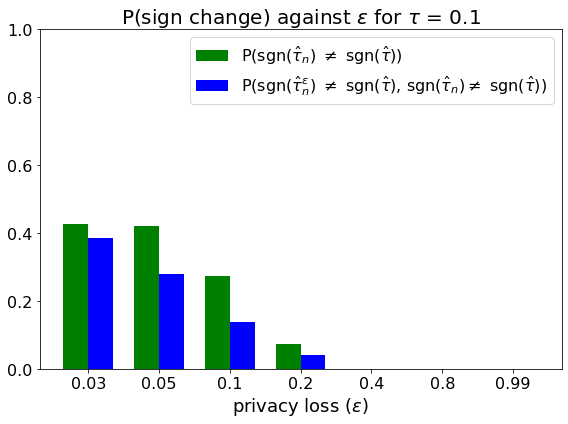

In [13]:
plot_hist('sim_tau_'+str(tau)+'_epses_flip_prob', tau, te_hats, te_hats_p, epses[1:], ne)

In [14]:
te, te_hats, te_hats_p, sig_d = IPW_PPS_Obj(X, T, prob_vec, Y, tau, epses, delta, reg_co, nf)

[0.084, 0.08, 0.032, 0.008, 0.002, 0.0, 0.0]
[0.034, 0.052, 0.026, 0.006, 0.002, 0.0, 0.0]


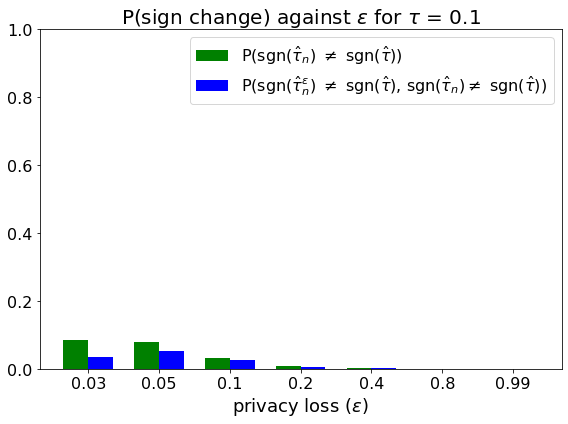

In [15]:
plot_hist('sim_tau_'+str(tau)+'_epses_flip_prob_obj', tau, te_hats, te_hats_p, epses[1:], ne)

In [16]:
# plot_hist_erf('hist_erf', tau, te_hats, te_hats_p, epses, sig_d)